<a href="https://colab.research.google.com/github/VulgarBOMB/spark_lab/blob/main/LAB_1_NechaevAzizovaLiskina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Инсталяция библиотеки PySpark
### Создание директорий для выгрузки итоговых паркетников
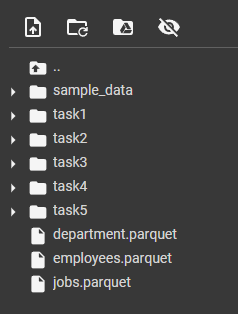

In [ ]:
!pip install pyspark
!mkdir task1
!mkdir task2
!mkdir task3
!mkdir task4
!mkdir task5

### Создание сессии PySpark под названием sparkProject

In [ ]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg

spark = SparkSession.builder.master("local[1]") \
                    .appName('sparkProject') \
                    .getOrCreate()

# Получение данных из паркетников
Реализация проверок на типы данных, дубликаты и Null-значения
```
checkDataTypes(df)
checkDuplicateRows(df)
checkWholeNullItem(df)
```



In [5]:
jobsDF = spark.read.parquet("jobs.parquet")
employeesDF = spark.read.parquet("employees.parquet")
departmentsDF = spark.read.parquet("department.parquet")

def checkDataTypes(jobsDF, departmentsDF, employeesDF):
  if dict(jobsDF.dtypes)['job_id'] != 'string'\
    or dict(jobsDF.dtypes)['job_title'] != 'string'\
    or dict(jobsDF.dtypes)['min_salary'] != 'float':
    print('Типы данных в JOBS некорректные')
    return False
  elif dict(departmentsDF.dtypes)['department_id'] != 'int'\
    or dict(departmentsDF.dtypes)['department_name'] != 'string':
    print('Типы данных в DEPARTMENTS некорректные')
    return False
  elif dict(employeesDF.dtypes)['first_name'] != 'string'\
    or dict(employeesDF.dtypes)['last_name'] != 'string'\
    or dict(employeesDF.dtypes)['job_id'] != 'string'\
    or dict(employeesDF.dtypes)['salary'] != 'float'\
    or dict(employeesDF.dtypes)['department_id'] != 'int':
    print('Типы данных в EMPLOYEES некорректные')
    return False
  else:
    print('Все типы данных корректные')
    return True

def checkWholeNullItem(jobsDF, departmentsDF, employeesDF):
  if jobsDF.filter(
      col('job_id').isNull() |
      col('job_title').isNull() |
      col('min_salary').isNull()
  ).count() > 0:
    print('JOBS имеет NULL-значения:')
    jobsDF.filter((col('job_id').isNull()) |
                  (col('job_title').isNull()) |
                  (col('min_salary').isNull())).show()
    return False
  elif departmentsDF.filter(
      col('department_id').isNull() |
      col('department_name').isNull()
  ).count() > 0:
    print('DEPARTMENTS имеет NULL-значения:')
    departmentsDF.filter((col('department_id').isNull()) |
                         (col('department_name').isNull())).show()
    return False
  elif employeesDF.filter(
      col('first_name').isNull() |
      col('last_name').isNull() |
      col('job_id').isNull() |
      col('salary').isNull() |
      col('department_id').isNull()
  ).count() > 0:
    print('EMPLOYEES имеет NUUL-значения:')
    employeesDF.filter((col('first_name').isNull()) |
                       (col('last_name').isNull()) |
                       (col('job_id').isNull()) |
                       (col('salary').isNull()) |
                       (col('department_id').isNull())).show()
    return False
  else:
    print('Нет NULL-значений в таблицах')
    return True

def checkDuplicateRows(jobsDF, departmentsDF, employeesDF):
  department_counts = departmentsDF\
    .groupBy("department_name")\
    .agg(count("*")\
    .alias("count"))\
    .filter(col("count") > 1)\
    .count()

  job_counts = jobsDF\
    .groupBy("job_title")\
    .agg(count("*")\
    .alias("count"))\
    .filter(col("count") > 1)\
    .count()

  employee_counts = employeesDF\
    .groupBy("first_name", "last_name", "job_id", "salary", "department_id")\
    .agg(count("*")\
    .alias("count"))\
    .filter(col("count") > 1)\
    .count()

  if (department_counts + job_counts + employee_counts) != 0:
    print('В одной из таблиц найдены дубликаты')
    return False
  else:
    print('Дубликаты не были найдены')
    return True

# ЗАДАЧА 1

In [6]:
if (checkDataTypes(jobsDF, departmentsDF, employeesDF) &
checkDuplicateRows(jobsDF, departmentsDF, employeesDF)):

  checkWholeNullItem(jobsDF, departmentsDF, employeesDF)

  emp = employeesDF.join(departmentsDF, departmentsDF.department_id == employeesDF.department_id, "inner")\
    .drop(departmentsDF.department_id)\
    .filter((departmentsDF.department_name == 'IT') | (departmentsDF.department_name == 'Sales'))\
    .select(employeesDF.first_name, employeesDF.last_name, departmentsDF.department_name)

  print('Первые 10 строк полученного DataFrame:')
  emp.limit(10).show()
  emp.write.partitionBy('department_name').mode('overwrite').parquet("/content/task1")
  print('Число строк в Employees: ' + str(employeesDF.count()))
  print('Число строк после запроса: ' + str(emp.count()))

else:
  print('Не пройдено одно из условий выше ↑')

Все типы данных корректные
Дубликаты не были найдены
EMPLOYEES имеет NUUL-значения:
+-----------+----------+---------+------+------------------+----------+------+------+--------------+----------+-------------+
|employee_id|first_name|last_name| email|      phone_number| hire_date|job_id|salary|commission_pct|manager_id|department_id|
+-----------+----------+---------+------+------------------+----------+------+------+--------------+----------+-------------+
|        178| Kimberely|    Grant|KGRANT|011.44.1644.429263|24.05.2007|SA_REP|7000.0|          0.15|       149|         NULL|
+-----------+----------+---------+------+------------------+----------+------+------+--------------+----------+-------------+

Первые 10 строк полученного DataFrame:
+----------+---------+---------------+
|first_name|last_name|department_name|
+----------+---------+---------------+
| Alexander|   Hunold|             IT|
|     Bruce|    Ernst|             IT|
|     David|   Austin|             IT|
|     Valli|

# ЗАДАЧА 2

In [7]:
if (checkDataTypes(jobsDF, departmentsDF, employeesDF) &
checkDuplicateRows(jobsDF, departmentsDF, employeesDF)):

  checkWholeNullItem(jobsDF, departmentsDF, employeesDF)

  emp = employeesDF.\
    join(departmentsDF, departmentsDF.department_id == employeesDF.department_id, "inner").\
    join(jobsDF, jobsDF.job_id == employeesDF.job_id, "inner").\
    filter(employeesDF.salary > 10000).\
    select(employeesDF.first_name, employeesDF.last_name, employeesDF.salary, departmentsDF.department_name, jobsDF.job_title).\
    orderBy(employeesDF.salary.asc())

  print('Первые 10 строк полученного DataFrame:')
  emp.limit(10).show()
  emp.write.partitionBy('department_name', 'job_title').mode('overwrite').parquet("/content/task2")
  print('Число строк в Employees: ' + str(employeesDF.count()))
  print('Число строк после запроса: ' + str(emp.count()))

else:
  print('Не пройдено одно из условий выше ↑')

Все типы данных корректные
Дубликаты не были найдены
EMPLOYEES имеет NUUL-значения:
+-----------+----------+---------+------+------------------+----------+------+------+--------------+----------+-------------+
|employee_id|first_name|last_name| email|      phone_number| hire_date|job_id|salary|commission_pct|manager_id|department_id|
+-----------+----------+---------+------+------------------+----------+------+------+--------------+----------+-------------+
|        178| Kimberely|    Grant|KGRANT|011.44.1644.429263|24.05.2007|SA_REP|7000.0|          0.15|       149|         NULL|
+-----------+----------+---------+------+------------------+----------+------+------+--------------+----------+-------------+

Первые 10 строк полученного DataFrame:
+----------+---------+-------+---------------+--------------------+
|first_name|last_name| salary|department_name|           job_title|
+----------+---------+-------+---------------+--------------------+
|     Eleni|  Zlotkey|10500.0|          Sa

# ЗАДАЧА 3

In [8]:
if (checkDataTypes(jobsDF, departmentsDF, employeesDF) &
checkDuplicateRows(jobsDF, departmentsDF, employeesDF)):

  checkWholeNullItem(jobsDF, departmentsDF, employeesDF)

  emp = employeesDF.\
    join(jobsDF, jobsDF.job_id == employeesDF.job_id, "inner").\
    filter((employeesDF.salary >= jobsDF.min_salary) & (employeesDF.salary <= jobsDF.min_salary*1.2)).\
    select(employeesDF.first_name.alias('Имя'), employeesDF.last_name.alias('Фамилия'), employeesDF.salary.alias('Оклад'), jobsDF.min_salary.alias('Минимальный оклад')).\
    orderBy(employeesDF.salary.asc())

  print('Первые 10 строк полученного DataFrame:')
  emp.limit(10).show()
  emp.write.partitionBy('Минимальный оклад').mode('overwrite').parquet("/content/task3")
  print('Число строк в Employees: ' + str(employeesDF.count()))
  print('Число строк после запроса: ' + str(emp.count()))

else:
  print('Не пройдено одно из условий выше ↑')

Все типы данных корректные
Дубликаты не были найдены
EMPLOYEES имеет NUUL-значения:
+-----------+----------+---------+------+------------------+----------+------+------+--------------+----------+-------------+
|employee_id|first_name|last_name| email|      phone_number| hire_date|job_id|salary|commission_pct|manager_id|department_id|
+-----------+----------+---------+------+------------------+----------+------+------+--------------+----------+-------------+
|        178| Kimberely|    Grant|KGRANT|011.44.1644.429263|24.05.2007|SA_REP|7000.0|          0.15|       149|         NULL|
+-----------+----------+---------+------+------------------+----------+------+------+--------------+----------+-------------+

Первые 10 строк полученного DataFrame:
+-------+----------+------+-----------------+
|    Имя|   Фамилия| Оклад|Минимальный оклад|
+-------+----------+------+-----------------+
|     TJ|     Olson|2100.0|           2008.0|
|  Hazel|Philtanker|2200.0|           2008.0|
| Steven|    Mar

# ЗАДАЧА 4

In [9]:
if (checkDataTypes(jobsDF, departmentsDF, employeesDF) &
checkDuplicateRows(jobsDF, departmentsDF, employeesDF)):

  checkWholeNullItem(jobsDF, departmentsDF, employeesDF)

  avg_salary = employeesDF.agg(avg(employeesDF.salary)).collect()[0][0]
  print('Средняя зарплата: ' + str(avg_salary))
  emp = employeesDF.\
    filter(employeesDF.salary > avg_salary).\
    select(employeesDF.last_name.alias('Фамилия_Р'), employeesDF.first_name.alias('Имя'), employeesDF.salary.alias('Оклад')).\
    orderBy(employeesDF.salary.asc())

  print('Первые 10 строк полученного DataFrame:')
  emp.limit(10).show()
  emp.write.partitionBy('Оклад').mode('overwrite').parquet("/content/task4")
  print('Число строк в Employees: ' + str(employeesDF.count()))
  print('Число строк после запроса: ' + str(emp.count()))

else:
  print('Не пройдено одно из условий выше ↑')

Все типы данных корректные
Дубликаты не были найдены
EMPLOYEES имеет NUUL-значения:
+-----------+----------+---------+------+------------------+----------+------+------+--------------+----------+-------------+
|employee_id|first_name|last_name| email|      phone_number| hire_date|job_id|salary|commission_pct|manager_id|department_id|
+-----------+----------+---------+------+------------------+----------+------+------+--------------+----------+-------------+
|        178| Kimberely|    Grant|KGRANT|011.44.1644.429263|24.05.2007|SA_REP|7000.0|          0.15|       149|         NULL|
+-----------+----------+---------+------+------------------+----------+------+------+--------------+----------+-------------+

Средняя зарплата: 6461.8317757009345
Первые 10 строк полученного DataFrame:
+---------+---------+------+
|Фамилия_Р|      Имя| Оклад|
+---------+---------+------+
|  Vollman|   Shanta|6500.0|
|   Mavris|    Susan|6500.0|
|      Lee|    David|6800.0|
|     Popp|     Luis|6900.0|
|  Tuv

# Задача 5

In [10]:
if (checkDataTypes(jobsDF, departmentsDF, employeesDF) &
checkDuplicateRows(jobsDF, departmentsDF, employeesDF)):

  checkWholeNullItem(jobsDF, departmentsDF, employeesDF)

  emp = employeesDF.\
    join(jobsDF, jobsDF.job_id == employeesDF.job_id, "inner").\
    filter(employeesDF.salary == jobsDF.min_salary).\
    select(employeesDF.first_name.alias('Имя'), employeesDF.last_name.alias('Фамилия'), jobsDF.job_title.alias('Должность'), employeesDF.salary.alias('Оклад'))

  print('Минимальные З/П по должностям')
  jobsDF.select(jobsDF.job_title, jobsDF.min_salary).\
    orderBy(jobsDF.min_salary.asc()).\
    show(20, False)

  print('Первые 10 строк полученного DataFrame:')
  emp.limit(10).show()
  emp.write.partitionBy('Должность').mode('overwrite').parquet("/content/task5")
  print('Число строк в Employees: ' + str(employeesDF.count()))
  print('Число строк после запроса: ' + str(emp.count()))

else:
  print('Не пройдено одно из условий выше ↑')

Все типы данных корректные
Дубликаты не были найдены
EMPLOYEES имеет NUUL-значения:
+-----------+----------+---------+------+------------------+----------+------+------+--------------+----------+-------------+
|employee_id|first_name|last_name| email|      phone_number| hire_date|job_id|salary|commission_pct|manager_id|department_id|
+-----------+----------+---------+------+------------------+----------+------+------+--------------+----------+-------------+
|        178| Kimberely|    Grant|KGRANT|011.44.1644.429263|24.05.2007|SA_REP|7000.0|          0.15|       149|         NULL|
+-----------+----------+---------+------+------------------+----------+------+------+--------------+----------+-------------+

Минимальные З/П по должностям
+-------------------------------+----------+
|job_title                      |min_salary|
+-------------------------------+----------+
|Stock Clerk                    |2008.0    |
|Purchasing Clerk               |2500.0    |
|Shipping Clerk               